Make sure that the Train_Val_Dataset.zip, DatasetYolo.zip, and image.c files have been uploaded to the colab files under the '/content' directory.

Also make sure that GPU is enabled in network settings.

## 1. Setup and Image Preprocessing

In [0]:
import torch
import numpy as np
import cv2 # computer vision library
import torch
import torchvision
import torchvision.transforms as transforms 
from torch.utils.data.sampler import SubsetRandomSampler 
import matplotlib.pyplot as plt 
import os 
import PIL 
from PIL import Image 
from PIL import ImageFilter 

In [2]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Create the folder for training and validation images. Our test images will come from the output of YoloV3 (discussed later).

In [3]:
%cd /content
!unzip '/content/Train_Val_Dataset.zip'

/content
Archive:  /content/Train_Val_Dataset.zip
replace Train_Val_Dataset/Green/20200318_142511_HDR-1(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):

    #apply gaussian blur to image
    blurred_img = image.filter(PIL.ImageFilter.GaussianBlur(3))

    #Make a copy of the inputted image
    #new_im = np.copy(image)
    new_im = np.copy(blurred_img)

    #Prepare for copping 
    rows = 3
    cols = 3
    #Cropping 4 rows from both upper and lower end of image 
    if (new_im.shape[0] > 50) and ((new_im.shape[1] > 50)):
      new_im = new_im[rows:-rows, cols:-cols,:]

    #Applying gaussian blur to image to remove noise
    #new_im = cv2.GaussianBlur(new_im, (3, 3), 0)


    #Resize to fit model dimensions
    new_im = cv2.resize(new_im,(32,32))
  
    return torchvision.transforms.functional.to_pil_image(new_im)

In [0]:
green = os.listdir('/content/Train_Val_Dataset/Green')
red = os.listdir('/content/Train_Val_Dataset/Red')
yellow = os.listdir('/content/Train_Val_Dataset/Yellow')

#get absolute paths of all images to be used for training and validation

green_paths = []
for image_name in green:
  green_paths.append('/content/Train_Val_Dataset/Green/' + image_name)

red_paths = []
for image_name in red:
  red_paths.append('/content/Train_Val_Dataset/Red/' + image_name)

yellow_paths = []
for image_name in yellow:
  yellow_paths.append('/content/Train_Val_Dataset/Yellow/' + image_name)

all_img_paths = green_paths + red_paths + yellow_paths

In [12]:
print("There are", len(green_paths), "green images.")
print("There are", len(red_paths), "red images.")
print("There are", len(yellow_paths), "yellow images.")

There are 336 green images.
There are 323 red images.
There are 342 yellow images.


In [0]:
#process the traffic light images and save them to there original directory, thus overwriting
#their previous version

for image_path in all_img_paths:
  print(image_path)
  img = Image.open(image_path)
  img_processed = standardize_input(img)
  img_processed.save(image_path)

##2. Data Loading and Splitting for Model 2 (classifier model).

Load the dataset from /Train_Val_Dataset and resize each image to 32x32 as well as converting each image to a tensor.

In [0]:
master_path = '/content/Train_Val_Dataset'

transform = transforms.Compose([transforms.Resize((32,32)), 
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(master_path, transform=transform)

This is our function to get the training and validation labeled images.

In [0]:
def get_data_loader(batch_size=1):
  size_data = len(dataset)
  indices = list(range(size_data))
  np.random.seed(200)
  np.random.shuffle(indices)

  # we want 30% of our data to be for validation leaving
  # 70% for training
  valratio = 0.15

  #assign the indices for train, validation
  valsplit = int(valratio*size_data)

  val_idx = indices[:valsplit]
  train_idx = indices[valsplit:]

  #define samplers
  train_sampler = SubsetRandomSampler(train_idx)
  val_sampler = SubsetRandomSampler(val_idx)

  #prepare the loaders
  train_loader = torch.utils.data.DataLoader(dataset, batch_size, num_workers=1, sampler=train_sampler)
  val_loader = torch.utils.data.DataLoader(dataset, batch_size, num_workers=1, sampler=val_sampler)
  
  return train_loader, val_loader

In [6]:
#lets see how many images we have in training and validation datasets
train_loader, val_loader = get_data_loader(batch_size=1)
print("There are ", len(train_loader), "images in the training set.")
print("There are ", len(val_loader), "images in the validation set.")

There are  851 images in the training set.
There are  150 images in the validation set.


## 3. Build the Classifier

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt                     # for plotting
import torch.optim as optim                         #for gradient descent
use_cuda = True
torch.manual_seed(1)

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        #input dimension: 32x32x3
        self.conv1 = nn.Conv2d(3, 4, 5)             #input channel:3  output channel:4  kernal size: 5x5  output dimension: (32+2*0-5)/1 + 1 = 28
        
        self.pool = nn.MaxPool2d(2, 2)              #kernal-size: 2   stride: 2       output dimenstion: (28+2*0-2)/2 + 1 = 14
        self.conv2 = nn.Conv2d(4, 10, 5)            #input channel:4  output channel:10    kernal size: 5x5   output dimension: (14+2*0-5)/1 + 1 = 10
        #Another MAX Pool                           #kernal-size: 2   stride: 2       output dimenstion: 10/2 = 5
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 4. Train the Classifier

Our training function.

In [0]:
def train(model, train_loader, val_loader, num_epochs=1, LR=0.001):
  torch.manual_seed(1000)
  criterion = nn.CrossEntropyLoss()      
  optimizer = optim.Adam(model.parameters(), lr=LR)

  train_acc, val_acc = [], []

  #training
  print("Training Started...")
  n = 0 #the number of iterations
  for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader):

      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      
      out = model(imgs)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      n += 1

    #track accuracy
    train_acc.append(get_accuracy(model, train_loader))
    val_acc.append(get_accuracy(model, val_loader))
    print(epoch, train_acc[-1], val_acc[-1])

  return train_acc, val_acc

Function that calculates the accuracy from a given dataset (can be training or validation).

In [0]:
def get_accuracy(model, data_loader):
  correct = 0
  total = 0
  for imgs, labels in data_loader:
    
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

    output = model(imgs)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
  return correct / total

Let's begin training. 

In [10]:
train_loader, val_loader = get_data_loader(batch_size=32)
num_epochs = 50

use_cuda = True
net_model = CNNClassifier()

if use_cuda and torch.cuda.is_available():
  net_model = net_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_acc, val_acc = train(net_model, train_loader, val_loader, num_epochs, 0.005)

CUDA is available!  Training on GPU ...
Training Started...
0 0.8131609870740305 0.8133333333333334
1 0.9247943595769683 0.9333333333333333
2 0.9682726204465335 0.96
3 0.981198589894242 0.98
4 0.9882491186839013 0.98
5 0.981198589894242 0.9666666666666667
6 0.982373678025852 0.9733333333333334
7 0.9917743830787309 1.0
8 0.9917743830787309 0.9866666666666667
9 0.9929494712103408 0.9866666666666667
10 0.9929494712103408 0.98
11 0.9776733254994124 0.9666666666666667
12 0.9882491186839013 0.9733333333333334
13 0.9952996474735605 1.0
14 0.9941245593419507 0.9933333333333333
15 0.9964747356051704 0.98
16 0.9964747356051704 0.9866666666666667
17 0.9964747356051704 0.9933333333333333
18 1.0 0.9933333333333333
19 1.0 0.9866666666666667
20 1.0 0.98
21 1.0 0.9933333333333333
22 1.0 0.9933333333333333
23 1.0 0.9933333333333333
24 1.0 0.9933333333333333
25 1.0 0.9933333333333333
26 1.0 0.9866666666666667
27 1.0 0.9866666666666667
28 1.0 0.9866666666666667
29 1.0 0.9866666666666667
30 1.0 0.99333333

Let's plot our training and validation accuracies over each epoch.

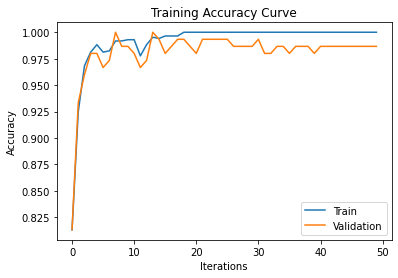

In [11]:
 #plot
  iters = list(range(num_epochs))
  plt.title("Training Accuracy Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

## 4. Set up YoloV3

Download the Darknet folder from the popular AlexeyAB github repository.

In [5]:
%cd /content
!git clone https://github.com/AlexeyAB/darknet

/content
Cloning into 'darknet'...
remote: Enumerating objects: 13039, done.
remote: Total 13039 (delta 0), reused 0 (delta 0), pack-reused 13039
Receiving objects: 100% (13039/13039), 11.76 MiB | 10.21 MiB/s, done.
Resolving deltas: 100% (8913/8913), done.


In [6]:
# change makefile to have GPU and OPENCV enabled
%cd /content/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [7]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


Recall that there is an image.c file with this project. This file should be in the /content folder of this colab document. If it isn't already, the following code will not work as expected.

In [8]:
# we must replace the image.c file in content/darknet/src folder with the 
# image.c given with the project 
#ONLY DO THIS ONCE
import os
import shutil

if os.path.exists('/content/darknet/src/image.c'):
  os.remove('/content/darknet/src/image.c')

shutil.move('/content/image.c', '/content/darknet/src')

'/content/darknet/src/image.c'

In [0]:
# make darknet (build)
%cd /content/darknet
!make

Now, we need to download the pretrained weights for Yolov3. This may take up to 10 min.

In [9]:
%cd /content/darknet
!wget https://pjreddie.com/media/files/yolov3.weights

/content/darknet
--2020-04-09 19:21:34--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   464KB/s    in 13m 9s  

2020-04-09 19:34:44 (307 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## 5. Run Yolov3 on Full-Sized Images.

We need to run our images through Yolov3 and extract the bounding boxes for each detectin in each image. We will do so by writing to a text file named boundaries.txt. This is done internally everytime Yolov3 is run.

Create the folder containing the images where traffic lights are going to be detected later.

In [0]:
%cd /content
!unzip '/content/DatasetYolo.zip'

Create a list containing the paths to all the images.

In [0]:
import os
green =  os.listdir('/content/DatasetYolo/Green')
red = os.listdir('/content/DatasetYolo/Red')
yellow = os.listdir('/content/DatasetYolo/Yellow')

num_green = len(green)
num_red = len(red)
num_yellow = len(yellow)

green_paths = []
for i in range(num_green):
  green_paths.append('/content/DatasetYolo/Green/' + green[i])

red_paths = []
for i in range(num_red):
  red_paths.append('/content/DatasetYolo/Red/' + red[i])

yellow_paths = []
for i in range(num_yellow):
  yellow_paths.append('/content/DatasetYolo/Yellow/' + yellow[i])

#combine all the paths
all_img_paths = green_paths + red_paths + yellow_paths
num_imgs = len(all_img_paths)

Run each image through YoloV3, which will write to the boundaries.txt file.

In [16]:
#delete the boundaries.txt file if it exists
import os
if os.path.exists('/content/darknet/src/boundaries.txt'):
  os.remove('/content/darknet/src/boundaries.txt')

#return to the darknet directory
%cd /content/darknet

for i in range(num_imgs):
  image_path = all_img_paths[i]
  !./darknet detector test 'cfg/coco.data' 'cfg/yolov3.cfg' 'yolov3.weights' {image_path}


Streaming output truncated to the last 5000 lines.
  96 conv    128       1 x 1/ 1     26 x  26 x 256 ->   26 x  26 x 128 0.044 BF
  97 upsample                 2x    26 x  26 x 128 ->   52 x  52 x 128
  98 route  97 36 	                           ->   52 x  52 x 384 
  99 conv    128       1 x 1/ 1     52 x  52 x 384 ->   52 x  52 x 128 0.266 BF
 100 conv    256       3 x 3/ 1     52 x  52 x 128 ->   52 x  52 x 256 1.595 BF
 101 conv    128       1 x 1/ 1     52 x  52 x 256 ->   52 x  52 x 128 0.177 BF
 102 conv    256       3 x 3/ 1     52 x  52 x 128 ->   52 x  52 x 256 1.595 BF
 103 conv    128       1 x 1/ 1     52 x  52 x 256 ->   52 x  52 x 128 0.177 BF
 104 conv    256       3 x 3/ 1     52 x  52 x 128 ->   52 x  52 x 256 1.595 BF
 105 conv    255       1 x 1/ 1     52 x  52 x 256 ->   52 x  52 x 255 0.353 BF
 106 yolo
[yolo] params: iou loss: mse (2), iou_norm: 0.75, cls_norm: 1.00, scale_x_y: 1.00
Total BFLOPS 65.879 
avg_outputs = 532444 
 Allocate additional workspace_size 

Read from the boundaries.txt file and format the read string into a list of dimensions of the form: [[image1bounds], [image2bounds], ....]

In [0]:
#read from the boundaries.txt file
f = open('/content/darknet/src/boundaries.txt')
boundaries_str = f.read()

In [13]:
#convert the string into a list of dimensions
boundaries_list = boundaries_str.split("END IMAGE")
boundaries_list.pop(-1) 

'\n'

In [0]:
boundaries = []
num = len(boundaries_list)
for i in range(num):
  img_bounds_str = boundaries_list[i]
  img_bounds_list = img_bounds_str.split('\n')
  img_bounds_list.pop(-1)                      #the last element is a '\n'
  if (i > 0):                                  #for all set of boundaries except the first, the first element is a '\n'
    img_bounds_list.pop(0)
  boundaries.append(img_bounds_list)


Compute the largest bounding boxes for each image.

In [0]:
# now out of each set of bounding boxes, we must find the largest box
# lets create a helper for that
def get_largest_box(boxes):
  area = 0
  num_boxes = len(boxes)
  ret_dim = []
  for i in range(num_boxes):
    dimensions = boxes[i].split(' ')   #dimensions = [left, top, right, bottom]
    left = int(dimensions[0])
    top = int(dimensions[1])
    right = int(dimensions[2])
    bottom = int(dimensions[3])
    this_area = (right - left) * (bottom - top)
    if this_area > area:
      area = this_area
      ret_dim = [left, top, right, bottom]
  return ret_dim

In [18]:
#using our helper function, lets find the largest box for each set of boxes
largest_boundaries = []
no_image_indices = []             #list of indices from boundaries where no traffic lights were detected
num_boundaries = len(boundaries)

for i in range(num_boundaries):
  if boundaries[i] == []:
    no_image.append(i)
    continue
  largest_boundaries.append(get_largest_box(boundaries[i]))

# quick sanity check
if len(largest_boundaries) == num_green + num_red + num_yellow:
  print("The sizes match up, ALL GOOD!!")

The sizes match up, ALL GOOD!!


Now we need to crop each original image based on the largest bounding box assiciated with each image. 

In [0]:
from PIL import Image
import torch
import torchvision

cropped_img_list = []
for i in range(num_imgs):
  if i in no_image_indices:
    continue
  img = Image.open(all_img_paths[i])
  left = largest_boundaries[i][0]
  top = largest_boundaries[i][1]
  right = largest_boundaries[i][2]
  bottom = largest_boundaries[i][3]
  img_cropped = torchvision.transforms.functional.crop(img, top, left, bottom-top, right-left)
  cropped_img_list.append(img_cropped)


Now lets run image processing on these cropped images.

In [0]:
processed_cropped_imgs = []
for i in range(len(cropped_img_list)):
  processed_cropped_imgs.append(standardize_input(cropped_img_list[i]))

Save the processed images in their respective Green, Red, and Yellow folders. These will be used for our testing set.

In [25]:
%cd /content
!mkdir Test_Dataset
%cd Test_Dataset
!mkdir Green
!mkdir Red
!mkdir Yellow

/content
/content/Test_Dataset


In [0]:
#calculate how many green labeled images had no detected traffic lights
num_green_missed = len([i for i in no_image_indices if (i < num_green)])
num_red_missed = len([i for i in no_image_indices if (i >= num_green and i < (num_green + num_red))])
num_yellow_missed = len([i for i in no_image_indices if (i >= (num_green + num_red))])

In [0]:
for i in range(len(processed_cropped_imgs)):
  if (i >= (num_green-num_green_missed) + (num_red-num_red_missed)):
    processed_cropped_imgs[i].save('/content/Test_Dataset/Yellow/yellow' + str(i) + '.jpg')
  elif(i >= (num_green-num_green_missed)):
    processed_cropped_imgs[i].save('/content/Test_Dataset/Red/red' + str(i) + '.jpg')
  else:
    processed_cropped_imgs[i].save('/content/Test_Dataset/Green/green' + str(i) + '.jpg') 


##6. Run Test Set Through Classifier model

In [0]:
master_path_test = '/content/Test_Dataset'

test_transform = transforms.Compose([transforms.Resize((32,32)), 
                                transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(master_path_test, transform=test_transform)

In [0]:
def get_data_loader_test(batch_size=1):
  size_data = len(test_dataset)
  indices = list(range(size_data))
  np.random.seed(203)
  np.random.shuffle(indices)

  test_sampler = SubsetRandomSampler(indices)

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, num_workers=1, sampler=test_sampler)

  return test_loader

In [0]:
def get_accuracy_test(model, data_loader):
  pred_yellow_actual_yellow = 0;
  pred_red_actual_yellow = 0;
  pred_green_actual_yellow = 0;
  pred_yellow_actual_red = 0;
  pred_red_actual_red = 0;
  pred_green_actual_red = 0;
  pred_yellow_actual_green = 0;
  pred_red_actual_green = 0;
  pred_green_actual_green = 0;
  got_wrong = []

  correct = 0
  total = 0
  for imgs, labels in data_loader:
    
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

    output = model(imgs)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]

    predicted = int(pred[0][0])
    actual = int(labels[0])
    if (predicted == 2 and actual == 2):
      pred_yellow_actual_yellow += 1
    if (predicted == 1 and actual == 2):
      pred_red_actual_yellow += 1
    if (predicted == 0 and actual == 2):
      pred_green_actual_yellow += 1
    if (predicted == 2 and actual == 1):
      pred_yellow_actual_red += 1
    if (predicted == 1 and actual == 1):
      pred_red_actual_red += 1
    if (predicted == 0 and actual == 1):
      pred_green_actual_red += 1
    if (predicted == 2 and actual == 0):
      pred_yellow_actual_green += 1
    if (predicted == 1 and actual == 0):
      pred_red_actual_green += 1
    if (predicted == 0 and actual == 0):
      pred_green_actual_green += 1
    if (predicted != actual):
      got_wrong.append((imgs, predicted))
          
  print("Predicted Yellow Actual Yellow: ", pred_yellow_actual_yellow)
  print("Predicted Red Actual Yellow ", pred_red_actual_yellow)
  print("Predicted Green Actual Yellow ", pred_green_actual_yellow)
  print("Predicted Yellow Actual Red", pred_yellow_actual_red)
  print("Predicted Red Actual Red", pred_red_actual_red)
  print("Predicted Green Actual Red", pred_green_actual_red)
  print("Predicted Yellow Actual Green", pred_yellow_actual_green)
  print("Predicted Red Actual Green", pred_red_actual_green)
  print("Predicted Green Actual Green", pred_green_actual_green)
  return correct / total, got_wrong

In [0]:
test_loader = get_data_loader_test(1)

In [27]:
accuracy, wrong = get_accuracy_test(net_model, test_loader)
accuracy

Predicted Yellow Actual Yellow:  35
Predicted Red Actual Yellow  11
Predicted Green Actual Yellow  4
Predicted Yellow Actual Red 13
Predicted Red Actual Red 31
Predicted Green Actual Red 6
Predicted Yellow Actual Green 11
Predicted Red Actual Green 4
Predicted Green Actual Green 35


0.6733333333333333